In [1]:
import os
import sys

module_path = os.path.abspath(os.path.join(".."))
if module_path not in sys.path:
    sys.path.append(module_path)
import models
from omegaconf import OmegaConf
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal, stats
import torch
import pyedflib

# Def Storage

In [2]:
def edf_extractor(file_name):
    f = pyedflib.EdfReader(file_name)
    n = f.signals_in_file
    signal_labels = f.getSignalLabels()
    sigbufs = np.zeros((n, f.getNSamples()[0]))
    for i in np.arange(n):
        sigbufs[i, :] = f.readSignal(i)
    return sigbufs, signal_labels

In [3]:
def plot_time_series(wav, smpl_rate):
    plt.figure(figsize=(10, 3))
    plt.xticks(fontsize=20)
    plt.yticks(fontsize=20)
    plt.ylabel("Voltage (\u03bcV)", fontsize=25)
    plt.xticks(
        np.arange(0, len(wav) + 1, smpl_rate),
        [x / smpl_rate for x in np.arange(0, len(wav) + 1, smpl_rate)],
    )
    plt.xlabel("Time (s)", fontsize=25)
    plt.plot(wav)

In [4]:
def get_stft(x, fs, clip_fs=-1, normalizing=None, **kwargs):
    f, t, Zxx = signal.stft(x, fs, **kwargs)

    Zxx = Zxx[:clip_fs]
    f = f[:clip_fs]

    Zxx = np.abs(Zxx)
    clip = 5  # To handle boundary effects
    if normalizing == "zscore":
        Zxx = Zxx[:, clip:-clip]
        Zxx = stats.zscore(Zxx, axis=-1)
        t = t[clip:-clip]
    elif normalizing == "baselined":
        Zxx = baseline(Zxx[:, clip:-clip])
        t = t[clip:-clip]
    elif normalizing == "db":
        Zxx = np.log2(Zxx[:, clip:-clip])
        t = t[clip:-clip]

    if np.isnan(Zxx).any():
        import pdb

        pdb.set_trace()

    return f, t, Zxx

In [5]:
def plot_stft(wav, SamplingFrequency):
    f, t, linear = get_stft(
        wav,
        SamplingFrequency,
        clip_fs=40,
        nperseg=400,
        noverlap=350,
        normalizing="zscore",
        return_onesided=True,
    )  # TODO hardcode sampling rate
    plt.figure(figsize=(15, 3))
    g1 = plt.pcolormesh(t, f, linear, shading="gouraud", vmin=-3, vmax=5)

    cbar = plt.colorbar(g1)
    tick_font_size = 15
    cbar.ax.tick_params(labelsize=tick_font_size)
    cbar.ax.set_ylabel("Power (Arbitrary units)", fontsize=15)
    plt.xticks(fontsize=20)
    plt.ylabel("")
    plt.yticks(fontsize=20)
    plt.xlabel("Time (s)", fontsize=20)
    plt.ylabel("Frequency (Hz)", fontsize=20)

In [6]:
def build_model(cfg):
    ckpt_path = cfg.upstream_ckpt
    init_state = torch.load(ckpt_path)
    upstream_cfg = init_state["model_cfg"]
    upstream = models.build_model(upstream_cfg)
    return upstream


def load_model_weights(model, states, multi_gpu):
    if multi_gpu:
        model.module.load_weights(states)
    else:
        model.load_weights(states)

# INIT

In [7]:
path_to = "/beegfs/home/g.soghoyan/George/ds004789-download/sub-R1001P/ses-0/ieeg/"
left_suff = "sub-R1001P_ses-0_task-FR1_acq-"
right_suff = "_ieeg.edf"
signal_types = ["monopolar", "bipolar"]
file_name = {}
recording = {}
signal_labels = {}
for s_type in signal_types:
    file_name[s_type] = f"{path_to}{left_suff}{s_type}{right_suff}"
    recording[s_type], signal_labels[s_type] = edf_extractor(file_name[s_type])

In [8]:
recording["monopolar"].shape

(88, 2349500)

In [9]:
recording["bipolar"].shape

(72, 2349500)

In [11]:
SamplingFrequency = 500

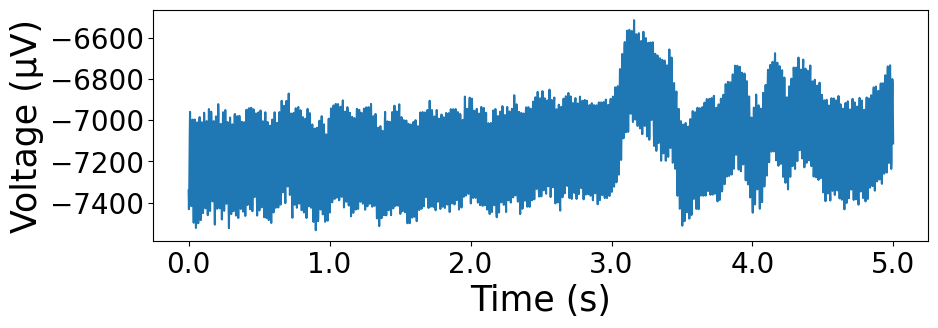

In [11]:
plot_time_series(recording["monopolar"][0][:2500], SamplingFrequency)

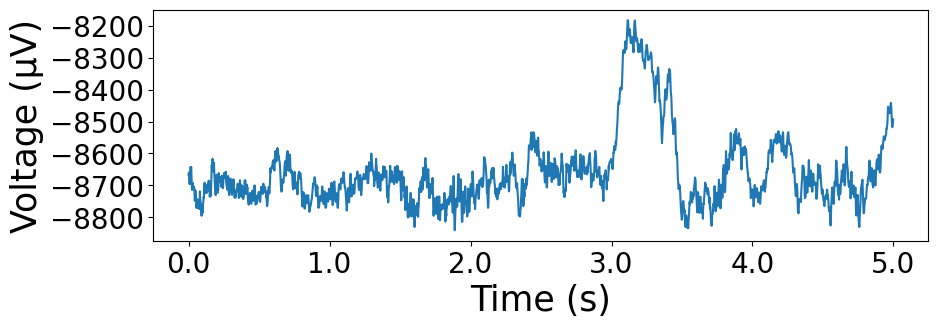

In [12]:
plot_time_series(recording["bipolar"][0][:2500], SamplingFrequency)

# STFT pictures

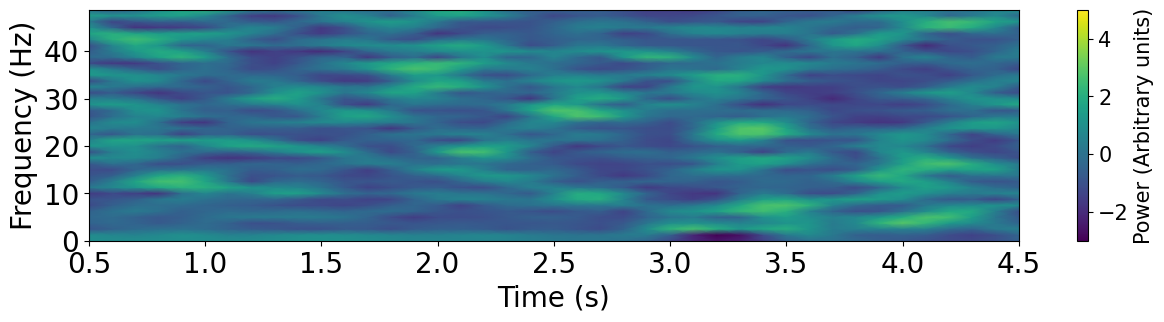

In [13]:
plot_stft(recording["monopolar"][0][:2500], SamplingFrequency)

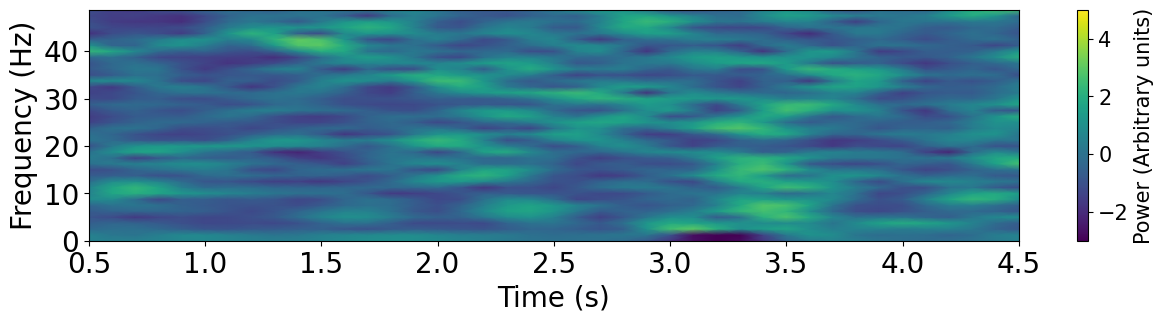

In [14]:
plot_stft(recording["bipolar"][0][:2500], SamplingFrequency)

# Model run through

In [8]:
ckpt_path = "/beegfs/home/g.soghoyan/George/BERT_init_weights/stft_large_pretrained.pth"
cfg = OmegaConf.create({"upstream_ckpt": ckpt_path})
model = build_model(cfg)
model.to("cuda")
init_state = torch.load(ckpt_path)
load_model_weights(model, init_state["model"], False)

/tmp/ipykernel_3208187/2987780488.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  init_state = torch.load(ckpt_path)
/trinity/home/g.soghoyan/.conda/envs/GeorgeEnv_BERT/

In [16]:
init_state["model_cfg"]

{'name': 'masked_tf_model', 'hidden_dim': 768, 'layer_dim_feedforward': 3072, 'layer_activation': 'gelu', 'nhead': 12, 'encoder_num_layers': 6, 'input_dim': 40}

In [21]:
f, t, linear = get_stft(
    recording["bipolar"][0][:2500],
    SamplingFrequency,
    clip_fs=40,
    nperseg=400,
    noverlap=350,
    normalizing="zscore",
    return_onesided=True,
)
inputs = torch.FloatTensor(linear).unsqueeze(0).transpose(1, 2).to("cuda")
mask = torch.zeros((inputs.shape[:2])).bool().to("cuda")
with torch.no_grad():
    out = model.forward(inputs, mask, intermediate_rep=True)

KeyError: 'bipolar'

In [15]:
chosen_rec = "bipolar"
framecap = 5000

In [19]:
# Получение данных STFT с обработкой всех каналов
stfts = []
for channel in range(recording[chosen_rec].shape[0]):  # Если это массив numpy
    f, t, linear = get_stft(
        recording[chosen_rec][channel, :][:framecap],  # Индексируем по оси каналов
        SamplingFrequency,
        clip_fs=40,
        nperseg=400,
        noverlap=350,
        normalizing="zscore",
    )
    stfts.append(linear)

# Конвертируем в тензор: [каналы=батч, время, частоты]
inputs = torch.FloatTensor(np.stack(stfts)).transpose(1, 2).to("cuda")

# Создаём маску (нужна модели)
mask = torch.zeros((inputs.shape[:2])).bool().to("cuda")

# Инференс
with torch.no_grad():
    out = model.forward(inputs, mask, intermediate_rep=True)

print(inputs.shape)  # [каналы, время, частоты]
print(out.shape)  # [каналы, время, 768] (или другое скрытое измерение модели)

torch.Size([72, 991, 40])
torch.Size([72, 991, 768])


In [20]:
inputs.shape, out.shape

(torch.Size([72, 991, 40]), torch.Size([72, 991, 768]))

In [21]:
f

array([ 0.  ,  1.25,  2.5 ,  3.75,  5.  ,  6.25,  7.5 ,  8.75, 10.  ,
       11.25, 12.5 , 13.75, 15.  , 16.25, 17.5 , 18.75, 20.  , 21.25,
       22.5 , 23.75, 25.  , 26.25, 27.5 , 28.75, 30.  , 31.25, 32.5 ,
       33.75, 35.  , 36.25, 37.5 , 38.75, 40.  , 41.25, 42.5 , 43.75,
       45.  , 46.25, 47.5 , 48.75])

In [22]:
t

array([ 0.5,  0.6,  0.7,  0.8,  0.9,  1. ,  1.1,  1.2,  1.3,  1.4,  1.5,
        1.6,  1.7,  1.8,  1.9,  2. ,  2.1,  2.2,  2.3,  2.4,  2.5,  2.6,
        2.7,  2.8,  2.9,  3. ,  3.1,  3.2,  3.3,  3.4,  3.5,  3.6,  3.7,
        3.8,  3.9,  4. ,  4.1,  4.2,  4.3,  4.4,  4.5,  4.6,  4.7,  4.8,
        4.9,  5. ,  5.1,  5.2,  5.3,  5.4,  5.5,  5.6,  5.7,  5.8,  5.9,
        6. ,  6.1,  6.2,  6.3,  6.4,  6.5,  6.6,  6.7,  6.8,  6.9,  7. ,
        7.1,  7.2,  7.3,  7.4,  7.5,  7.6,  7.7,  7.8,  7.9,  8. ,  8.1,
        8.2,  8.3,  8.4,  8.5,  8.6,  8.7,  8.8,  8.9,  9. ,  9.1,  9.2,
        9.3,  9.4,  9.5,  9.6,  9.7,  9.8,  9.9, 10. , 10.1, 10.2, 10.3,
       10.4, 10.5, 10.6, 10.7, 10.8, 10.9, 11. , 11.1, 11.2, 11.3, 11.4,
       11.5, 11.6, 11.7, 11.8, 11.9, 12. , 12.1, 12.2, 12.3, 12.4, 12.5,
       12.6, 12.7, 12.8, 12.9, 13. , 13.1, 13.2, 13.3, 13.4, 13.5, 13.6,
       13.7, 13.8, 13.9, 14. , 14.1, 14.2, 14.3, 14.4, 14.5, 14.6, 14.7,
       14.8, 14.9, 15. , 15.1, 15.2, 15.3, 15.4, 15

In [23]:
linear

array([[-1.77196146, -1.56347502, -1.08837998, ...,  1.40482953,
         1.10409983,  0.79117151],
       [-2.44043302, -1.56822885, -0.5856144 , ...,  1.42897032,
         0.91343215,  0.49800944],
       [ 3.08891534,  1.66522137, -0.28115041, ..., -0.37867336,
        -0.49080101, -1.15287043],
       ...,
       [ 1.35823172,  1.64835305,  1.30802631, ...,  0.62590834,
        -0.67415678, -1.65464801],
       [ 0.03321848, -0.77385924, -0.84021262, ...,  0.07347349,
        -1.17558756, -1.23564191],
       [-0.04093781,  0.10050924,  0.24311512, ...,  0.11486324,
        -0.6801825 , -0.93522451]])

In [19]:
import matplotlib.pyplot as plt
import numpy as np
import torch
from fpdf import FPDF
import random

path_to = "/beegfs/home/g.soghoyan/George/ds004789-download/sub-R1001P/ses-0/ieeg/"
left_suff = "sub-R1001P_ses-0_task-FR1_acq-"
right_suff = "_ieeg.edf"
signal_types = ["monopolar", "bipolar"]
file_name = {}
recording = {}
signal_labels = {}
for s_type in signal_types:
    file_name[s_type] = f"{path_to}{left_suff}{s_type}{right_suff}"
    recording[s_type], signal_labels[s_type] = edf_extractor(file_name[s_type])

SamplingFrequency = 500
chosen_rec = "bipolar"
framecap = 50000

ckpt_path = "/beegfs/home/g.soghoyan/George/BERT_init_weights/stft_large_pretrained.pth"
cfg = OmegaConf.create({"upstream_ckpt": ckpt_path})
model = build_model(cfg)
model.to("cuda")
init_state = torch.load(ckpt_path)
load_model_weights(model, init_state["model"], False)


# Функция для расчёта метрик
def calculate_metrics(data):
    return {
        "mean": np.mean(data),
        "std": np.std(data),
        "median": np.median(data),
    }


# Параметры
fs = SamplingFrequency  # Частота семплирования

import csv

# Путь к CSV-файлу
csv_file_path = "intervals.csv"

# Пустые списки для хранения данных
intervals = []
interval_activity = []

# Чтение CSV-файла
with open(csv_file_path, mode="r", encoding="utf-8") as csv_file:
    csv_reader = csv.reader(csv_file)

    for row in csv_reader:
        # Разбираем строки: первое значение — активность, второе и третье — начало и конец интервала
        activity = row[0]
        start = float(row[1])
        end = float(row[2])

        interval_activity.append(activity)
        intervals.append((start, end))

model_outputs = []
num_electrodes = 8

# Генерация случайных отобранных электродов
selected_electrodes = random.sample(range(72), num_electrodes)

# Обработка интервалов
for start, end in intervals:
    # Генерация STFT для всех каналов
    stfts = []
    for channel in range(recording[chosen_rec].shape[0]):
        start_idx = int(start * fs)
        end_idx = int(end * fs)
        f, t, linear = get_stft(
            recording[chosen_rec][channel, start_idx:end_idx],
            fs,
            clip_fs=40,
            nperseg=400,
            noverlap=350,
            normalizing="zscore",
        )
        stfts.append(linear)

    # Форматирование тензоров и инференс модели
    inputs = torch.FloatTensor(np.stack(stfts)).transpose(1, 2).to("cuda")
    mask = torch.zeros((inputs.shape[:2])).bool().to("cuda")

    print("Input shape:", inputs.shape)
    print("Mask shape:", mask.shape)

    with torch.no_grad():
        out = model.forward(inputs, mask, intermediate_rep=True)

    model_outputs.append(out.cpu().numpy())

# Генерация PDF
pdf = FPDF(orientation="L", unit="mm", format="A4")
pdf.set_auto_page_break(auto=True, margin=10)

for interval_idx, (start, end) in enumerate(intervals):
    interval_output = model_outputs[interval_idx]  # Выходы модели для интервала
    interval_activity = np.mean(interval_output)  # Средняя активность интервала

    # Расчёт евклидовых расстояний
    distances = np.linalg.norm(interval_output, axis=2).mean(axis=1)

    # Категории электродов
    best_electrodes = np.argsort(distances)[:num_electrodes]
    worst_electrodes = np.argsort(distances)[-num_electrodes:]

    for category, electrodes in zip(
        ["Лучшее", "Худшее", "Избранное"],
        [best_electrodes, worst_electrodes, selected_electrodes],
    ):
        fig, axs = plt.subplots(2, 4, figsize=(16, 8), constrained_layout=True)
        axs = axs.flatten()

        for i, ax in enumerate(axs):
            if i >= len(electrodes):
                ax.axis("off")
                continue

            electrode = electrodes[i]
            electrode_data = interval_output[electrode]

            # Метрики
            metrics = calculate_metrics(electrode_data.flatten())
            mean, std, median = metrics["mean"], metrics["std"], metrics["median"]

            # Построение графика
            im = ax.imshow(
                electrode_data, aspect="auto", origin="lower", cmap="viridis"
            )
            ax.set_title(f"Электрод {electrode}")
            ax.set_xlabel("Скрытое измерение")
            ax.set_ylabel("Временные шаги")
            fig.colorbar(im, ax=ax, label="Активность")

            # Метрики на графике
            ax.text(
                0.95,
                0.95,
                f"Mean: {mean:.2f}\nSTD: {std:.2f}\nMedian: {median:.2f}",
                transform=ax.transAxes,
                fontsize=8,
                va="top",
                ha="right",
                bbox=dict(boxstyle="round", facecolor="white", alpha=0.8),
            )

        plt.suptitle(
            f"Интервал {start:.3f}-{end:.3f} сек, активность {interval_activity}, {category}"
        )

        # Сохранение страницы
        image_path = f"interval_{interval_idx}_{category}.png"
        plt.savefig(image_path, dpi=300)
        plt.close()

        pdf.add_page()
        pdf.image(image_path, x=10, y=10, w=277)

# Сохранение PDF
pdf.output("electrode_intervals.pdf")
print("PDF-документ успешно создан!")

KeyboardInterrupt: 